In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    f1_score, precision_score, recall_score, roc_auc_score,
    roc_curve, precision_recall_curve
)
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [18]:
df = pd.read_excel('engineered_features.xlsx')
print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['is_late'].value_counts())
print(f"\nLate percentage: {(df['is_late'] == 'late').mean()*100:.2f}%")
numerical_features =  df.select_dtypes(include=[np.number]).columns.tolist()

categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

X = df[numerical_features + categorical_features].copy()
y = (df['is_late'] == 'late').astype(int)

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"\nMissing values in X:")
print(X.isnull().sum())


Dataset shape: (3434, 38)

Target distribution:
is_late
1    1717
0    1717
Name: count, dtype: int64

Late percentage: 0.00%
Numerical features (6): ['is_late', 'order_hour', 'distance_km', 'delivery_partner_orders', 'restaurant_rating', 'restaurant_avg_prep_min']
Categorical features (32): ['is_peak_hour_True', 'is_promo_order_True', 'day_of_week_monday_True', 'day_of_week_saturday_True', 'day_of_week_sunday_True', 'day_of_week_thursday_True', 'day_of_week_tuesday_True', 'day_of_week_wednesday_True', 'restaurant_type_casual_dining_True', 'restaurant_type_cloud_kitchen_True', 'restaurant_type_fast_food_True', 'restaurant_type_fine_dining_True', 'cuisine_type_chinese_True', 'cuisine_type_dessert_True', 'cuisine_type_healthy_True', 'cuisine_type_indian_True', 'cuisine_type_italian_True', 'cuisine_type_other_True', 'cuisine_type_pizza_burger_True', 'cuisine_type_south_indian_True', 'weather_condition_fog_True', 'weather_condition_heavy_rain_True', 'weather_condition_hot_True', 'weather_c

In [19]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)


model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train class distribution: {y_train.value_counts().to_dict()}")
print(f"Test class distribution: {y_test.value_counts().to_dict()}")


Training set: 2747 samples
Test set: 687 samples
Train class distribution: {0: 2747}
Test class distribution: {0: 687}


In [20]:
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
train_accuracy = model_pipeline.score(X_train, y_train)
test_accuracy = model_pipeline.score(X_test, y_test)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
print("\nCross-Validation (5-fold):")
cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")



Cross-Validation (5-fold):
CV Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0000 (+/- 0.0000)


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['On-Time', 'Late']))



Classification Report:


ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

In [ ]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives(On-Time predicted correctly): {cm[0,0]}")
print(f"False Positives(On-Time predicted as Late): {cm[0,1]}")
print(f"False Negative(Late predicted as On-Time): {cm[1,0]}")
print(f"True Positives(Late predicted correctly): {cm[1,1]}")



Confusion Matrix:
[[282  81]
 [162  75]]

True Negatives(On-Time predicted correctly): 282
False Positives(On-Time predicted as Late): 81
False Negative(Late predicted as On-Time): 162
True Positives(Late predicted correctly): 75


In [ ]:
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_features).tolist()
all_feature_names = numerical_features + cat_feature_names

importances = model_pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))



Top 15 Most Important Features:
                 feature  importance
 delivery_partner_orders    0.097311
 restaurant_avg_prep_min    0.094941
         order_value_inr    0.090642
             distance_km    0.089224
 delivery_partner_rating    0.075166
  estimated_delivery_min    0.074159
       restaurant_rating    0.069735
              order_hour    0.053531
               num_items    0.052149
traffic_density_gridlock    0.031532
            is_peak_hour    0.018768
traffic_density_moderate    0.012496
   area_type_residential    0.012277
 weather_condition_clear    0.011649
   traffic_density_heavy    0.010683


In [ ]:
import joblib

joblib.dump(model_pipeline, 'delivery_model_pipeline.pkl')
feature_info = {
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'all_feature_names': all_feature_names
}
joblib.dump(feature_info, 'feature_info.pkl')

['feature_info.pkl']

In [ ]:
print(f"\nACCURACY: {accuracy_score(y_test, y_pred):.4f}")
print(f"PRECISION: {precision_score(y_test, y_pred):.4f}")
print(f"RECALL: {recall_score(y_test, y_pred):.4f}")
print(f"F1 SCORE (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1 SCORE (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 SCORE (late class): {f1_score(y_test, y_pred, pos_label=1):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")



ACCURACY: 0.5950
PRECISION: 0.4808
RECALL: 0.3165
F1 SCORE (macro): 0.5403
F1 SCORE (weighted): 0.5736
F1 SCORE (late class): 0.3817
ROC-AUC: 0.5959



CV F1 Scores: [0.40462428 0.42071197 0.39375    0.39482201 0.4244373 ]
Mean CV F1: 0.40766911141490836 (0.0256)

True Negatives: 282
False Positives: 81
False Negatives: 162
True Positives: 75

Specificity: 0.7769
Sensitivity: 0.3165
Precision: 0.4808
              precision    recall  f1-score   support

     On-Time       0.64      0.78      0.70       363
        Late       0.48      0.32      0.38       237

    accuracy                           0.59       600
   macro avg       0.56      0.55      0.54       600
weighted avg       0.57      0.59      0.57       600



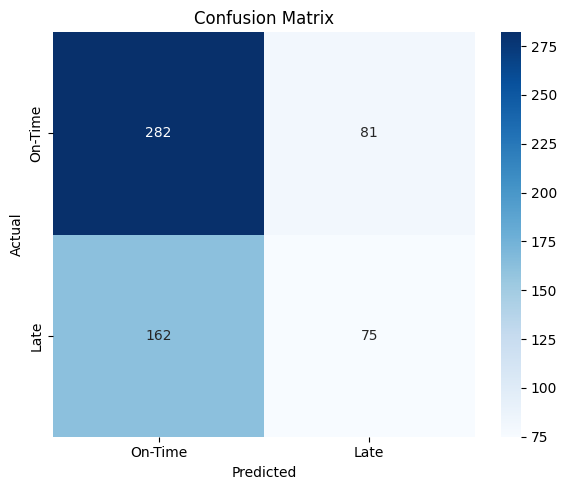

In [ ]:
cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"\nCV F1 Scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():} ({cv_scores.std()*2:.4f})")
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"\nSpecificity: {tn/(tn+fp):.4f}")
print(f"Sensitivity: {tp/(tp+fn):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(classification_report(y_test, y_pred, target_names=['On-Time', 'Late']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['On-Time', 'Late'],
            yticklabels=['On-Time', 'Late'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()


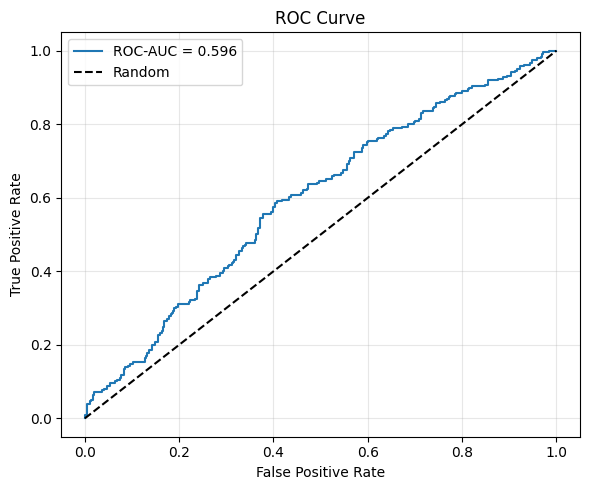

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc_score(y_test, y_pred_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()


ValueError: x and y must have same first dimension, but have shapes (601,) and (600,)

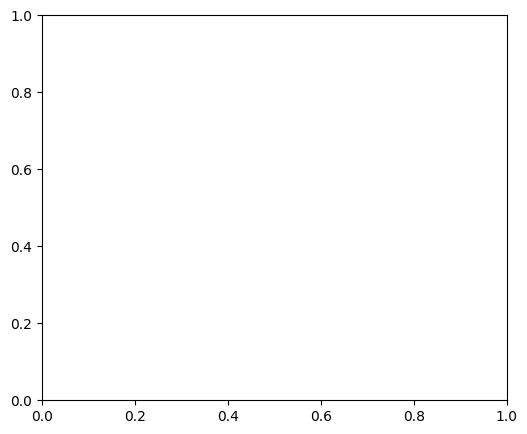

In [ ]:
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals[:-1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(alpha=0.3)
plt.tight_layout()

ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(categorical_features).tolist()
all_names = numerical_features + cat_names
importances = model_pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.DataFrame({'feature': all_names, 'importance': importances}).sort_values('importance', ascending=False)


In [ ]:
plt.figure(figsize=(8, 10))
plt.barh(range(15), feat_imp['importance'].head(15)[::-1])
plt.yticks(range(15), feat_imp['feature'].head(15)[::-1], fontsize=8)
plt.xlabel('Importance')
plt.title('Top 15 Features')
plt.tight_layout()

joblib.dump(model_pipeline, 'delivery_model.pkl')
joblib.dump({'numerical': numerical_features, 'categorical': categorical_features}, 'features.pkl')
print("Saved: delivery_model.pkl, features.pkl")